# **English-to-Hindi Translator :-**
This project implements an English-to-Hindi Translator using an Encoder-Decoder model with attention.

# **Dataset Link :-**

https://www.kaggle.com/datasets/preetviradiya/english-hindi-dataset

# **Setting up Directory**

In [ ]:
%%capture
!pip install indic-nlp-library

In [ ]:
# For PyTorch 2.2.2 and torchtext 0.17.2
!pip install torch==2.2.2
!pip install torchtext==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# **Importing Libraries**

In [ ]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import torchtext
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.functional import one_hot
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import os
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from indicnlp.tokenize import indic_tokenize

# **Reading Data**

In [ ]:
df = pd.read_csv('Dataset_English_Hindi.csv')

In [ ]:
df.shape

(130476, 2)

**Taking only 500 data**

In [ ]:
df = df.iloc[:500,:]

In [ ]:
df.head()

,English,Hindi
0,Help!,बचाओ!
1,Jump.,उछलो.
2,Jump.,कूदो.
3,Jump.,छलांग.
4,Hello!,नमस्ते।


In [ ]:
df.tail()

,English,Hindi
495,The trees are green.,पेड़ हरे हैं।
496,These are our books.,ये हमारी किताबें हैं।
497,This is what I need.,यह वही चीज़ है जिसकी मुझे ज़रूरत है।
498,Watch your language.,ज़बान सम्भाल के बात करो।
499,We are good friends.,हम अच्छे दोस्त हैं।


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  500 non-null    object
 1   Hindi    500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


# **Preprocessing**

In [ ]:
# Handling the encoding issue by removing the rows.
def is_hindi_corrupted(text):
    if re.search(r'[^\u0900-\u097F\s,.?!-]', text):
        return True
    return False

In [ ]:
# Apply the function to the 'Hindi' column to create a mask
df['Corrupted'] = df['Hindi'].apply(is_hindi_corrupted)

# Filter out corrupted rows
df_clean = df[~df['Corrupted']]

# Drop the 'Corrupted' column as it's no longer needed
df_clean = df_clean.drop(columns=['Corrupted'])

In [ ]:
df_clean.shape

(499, 2)

In [ ]:
df_clean.head()

,English,Hindi
0,Help!,बचाओ!
1,Jump.,उछलो.
2,Jump.,कूदो.
3,Jump.,छलांग.
4,Hello!,नमस्ते।


In [ ]:
df_clean.iloc[20:30]

,English,Hindi
20,Have fun.,मौज करना।
21,Have fun.,मज़े करो।
22,I forgot.,मैं भूल गया।
23,I forgot.,मैं भूल गई।
24,I'll pay.,मैं पैसे दूंगा।
25,I'm fine.,मैं ठीक हूँ।
26,I'm full.,मेरा पेट भर गया है।
27,Let's go!,चलो चलें!
28,Answer me.,मुझे जवाब दो।
29,Birds fly.,पंछी उड़ते हैं।


In [ ]:
def clean_text(text, language="english"):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKC', text)
    # Convert to lowercase if the text is in English
    if language == "english":
        text = text.lower()

        # Decontracting words
        contractions = {
           "ain't": "am not",
           "aren't": "are not",
           "can't": "can not",
           "can't've": "can not have",
           "'cause": "because",
           "could've": "could have",
           "couldn't": "could not",
           "couldn't've": "could not have",
           "didn't": "did not",
           "doesn't": "does not",
           "don't": "do not",
           "hadn't": "had not",
           "hadn't've": "had not have",
           "hasn't": "has not",
           "haven't": "have not",
           "he'd": "he would",
           "he'd've": "he would have",
           "he'll": "he will",
           "he'll've": "he will have",
           "he's": "he is",
           "how'd": "how did",
           "how'd'y": "how do you",
           "how'll": "how will",
           "how's": "how is",
           "i'd": "i would",
           "i'd've": "i would have",
           "i'll": "i will",
           "i'll've": "i will have",
           "i'm": "i am",
           "i've": "i have",
           "isn't": "is not",
           "it'd": "it would",
           "it'd've": "it would have",
           "it'll": "it will",
           "it'll've": "it will have",
           "it's": "it is",
           "let's": "let us",
           "ma'am": "madam",
           "mayn't": "may not",
           "might've": "might have",
           "mightn't": "might not",
           "mightn't've": "might not have",
           "must've": "must have",
           "mustn't": "must not",
           "mustn't've": "must not have",
           "needn't": "need not",
           "needn't've": "need not have",
           "o'clock": "of the clock",
           "oughtn't": "ought not",
           "oughtn't've": "ought not have",
           "shan't": "shall not",
           "sha'n't": "shall not",
           "shan't've": "shall not have",
           "she'd": "she would",
           "she'd've": "she would have",
           "she'll": "she will",
           "she'll've": "she will have",
           "she's": "she is",
           "should've": "should have",
           "shouldn't": "should not",
           "shouldn't've": "should not have",
           "so've": "so have",
           "so's": "so as",
           "that'd": "that would",
           "that'd've": "that would have",
           "that's": "that is",
           "there'd": "there would",
           "there'd've": "there would have",
           "there's": "there is",
           "they'd": "they would",
           "they'd've": "they would have",
           "they'll": "they will",
           "they'll've": "they will have",
           "they're": "they are",
           "they've": "they have",
           "to've": "to have",
           "wasn't": "was not",
           "we'd": "we would",
           "we'd've": "we would have",
           "we'll": "we will",
           "we'll've": "we will have",
           "we're": "we are",
           "we've": "we have",
           "weren't": "were not",
           "what'll": "what will",
           "what'll've": "what will have",
           "what're": "what are",
           "what's": "what is",
           "what've": "what have",
           "when's": "when is",
           "when've": "when have",
           "where'd": "where did",
           "where's": "where is",
           "where've": "where have",
           "who'll": "who will",
           "who'll've": "who will have",
           "who's": "who is",
           "who've": "who have",
           "why's": "why is",
           "why've": "why have",
           "will've": "will have",
           "won't": "will not",
           "won't've": "will not have",
           "would've": "would have",
           "wouldn't": "would not",
           "wouldn't've": "would not have",
           "y'all": "you all",
           "y'all'd": "you all would",
           "y'all'd've": "you all would have",
           "y'all're": "you all are",
           "y'all've": "you all have",
           "you'd": "you would",
           "you'd've": "you would have",
           "you'll": "you will",
           "you'll've": "you will have",
           "you're": "you are",
           "you've": "you have"
          }

        q_decontracted = []

        for word in text.split():
          if word in contractions:
            word = contractions[word]

          q_decontracted.append(word)

        text = ' '.join(q_decontracted)


        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)

    # Remove any English words present in Hindi text.
    if language == "hindi":
        text = re.sub('[a-zA-Z]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)


    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df_clean["English"] = df_clean["English"].apply(clean_text)
df_clean["Hindi"] = df_clean['Hindi'].apply(clean_text, args=("hindi",))

In [ ]:
df_clean.shape

(499, 2)

In [ ]:
df_clean.iloc[20:30]

,English,Hindi
20,have fun,मौज करना।
21,have fun,मज़े करो।
22,i forgot,मैं भूल गया।
23,i forgot,मैं भूल गई।
24,i will pay,मैं पैसे दूंगा।
25,i am fine,मैं ठीक हूँ।
26,i am full,मेरा पेट भर गया है।
27,let us go,चलो चलें!
28,answer me,मुझे जवाब दो।
29,birds fly,पंछी उड़ते हैं।


# **Numbers of Words per Sentence**

In [ ]:
df_clean['English_Words'] = df_clean['English'].apply(lambda x: len(x.split()))
df_clean['Hindi_Words'] = df_clean['Hindi'].apply(lambda x: len(x.split()))

In [ ]:
df_clean.head()

,English,Hindi,English_Words,Hindi_Words
0,help,बचाओ!,1,1
1,jump,उछलो.,1,1
2,jump,कूदो.,1,1
3,jump,छलांग.,1,1
4,hello,नमस्ते।,1,1


In [ ]:
# Calculate averages
average_english_words = df_clean['English_Words'].median()
average_hindi_words = df_clean['Hindi_Words'].median()

average_english_words , average_hindi_words

(4.0, 4.0)

In [ ]:
# Calculate maximum
max_english_words = df_clean['English_Words'].quantile(.99)
max_hindi_words = df_clean['Hindi_Words'].quantile(.99)

max_english_words , max_hindi_words

(np.float64(6.0), np.float64(7.019999999999982))

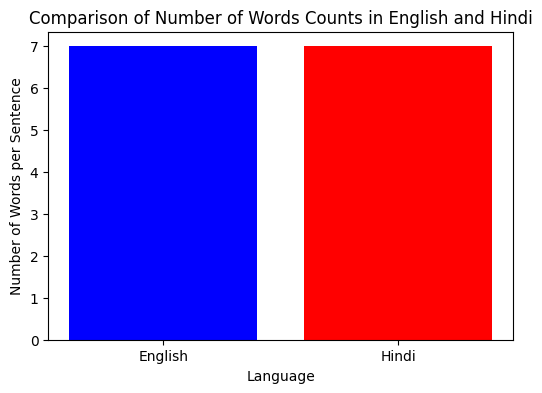

In [ ]:
# Calculate averages
average_english_words = df_clean['English_Words'].quantile(.50)
average_hindi_words = df_clean['Hindi_Words'].quantile(.50)

# Data for plotting
averages = [average_english_words, average_hindi_words]
languages = ['English', 'Hindi']

# Creating the plot
plt.figure(figsize=(6, 4))
plt.bar(languages, averages, color=['blue', 'red'])
plt.xlabel('Language')
plt.ylabel('Number of Words per Sentence')
plt.title('Comparison of Number of Words Counts in English and Hindi')
plt.show()

# **Tokenizing**

In [ ]:
tokenizer_eng = get_tokenizer('basic_english')
tokenizer_hin = indic_tokenize.trivial_tokenize  # This is the Hindi tokenizer from Indic NLP

tokenized_english_txt = [tokenizer_eng(english_sen) for english_sen in df_clean['English'] ]
tokenized_hindi_txt = [tokenizer_hin(hindi_sen) for hindi_sen in df_clean['Hindi'] ]

In [ ]:
print(tokenized_english_txt[:5])
print(tokenized_hindi_txt[:5])

[['help'], ['jump'], ['jump'], ['jump'], ['hello']]
[['बचाओ', '!'], ['उछलो', '.'], ['कूदो', '.'], ['छलांग', '.'], ['नमस्ते', '।']]


### **Removing Punctuations from hindi text**

In [ ]:
import string
punct = string.punctuation
punct = punct + '।'
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~।'

In [ ]:
def remove_punctuations(tokenized):
  for sent in tokenized:
    for token in sent:
      if token in punct:
        sent.remove(token)
  return tokenized

In [ ]:
# Total words before punctuations
total_words = 0
for sent in tokenized_hindi_txt:
  for word in sent:
    total_words += 1
print(total_words)

2556


In [ ]:
tokenized_hindi_txt = remove_punctuations(tokenized_hindi_txt)

In [ ]:
# Total words after removing punctuations
total_words = 0
for sent in tokenized_hindi_txt:
  for word in sent:
    total_words += 1
print(total_words)

2048


In [ ]:
print(tokenized_hindi_txt[400:410])

[['अभी', 'से', 'रात', 'हो', 'गई', 'है'], ['बरफ़', 'जैसा', 'दिखता', 'है'], ['बरफ़', 'गिरनी', 'शुरू', 'गो', 'गई'], ['मेरा', 'है', 'उसका', 'नहीं'], ['मेरी', 'है', 'उसकी', 'नहीं'], ['बहुत', 'महंगा', 'है'], ['बहुत', 'महंगी', 'है'], ['यहाँ', 'बहुत', 'गरम', 'है'], ['यह', 'मुझे', 'संभालने', 'दो'], ['रेलगाड़ी', 'से', 'चलते', 'हैं']]


# **Building Vocabulary**

In [ ]:
# Step 3: Building Vocabulary
features_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_english_txt, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
target_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_hindi_txt, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

features_vocab.set_default_index(features_vocab['<unk>'])
target_vocab.set_default_index(target_vocab['<unk>'])

### **Saving these vocab**

In [ ]:
import torch

# Save the vocabularies
torch.save(features_vocab , 'features_vocab.pth')
torch.save(target_vocab , 'target_vocab.pth')

In [ ]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [ ]:
print(features_vocab_total_words)  #English
print(target_vocab_total_words)    #Hindi

476
624


In [ ]:
features_vocab['<unk>'] , features_vocab['<pad>'] , features_vocab['<bos>'] , features_vocab['<eos>']

(0, 1, 2, 3)

# **Getting of Indices of Tokens**

In [ ]:
def tokens_to_indices(tokenized_texts, vocab):
    indices_texts = []
    for sentence in tokenized_texts:
        indices_texts.append([vocab[token] for token in sentence if token in vocab])
    return indices_texts

In [ ]:
english_indices = tokens_to_indices(tokenized_english_txt, features_vocab)
hindi_indices = tokens_to_indices(tokenized_hindi_txt, target_vocab)

In [ ]:
len(english_indices) , len(hindi_indices)

(499, 499)

In [ ]:
hindi_indices[:10]

[[476],
 [286],
 [313],
 [372],
 [435],
 [434],
 [244, 244],
 [365],
 [586, 121, 12],
 [5, 79, 7]]

# **Creating Dataset**

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, english_data, hindi_data):
        self.english_data = english_data
        self.hindi_data = hindi_data

    def __len__(self):
        return len(self.english_data)

    def __getitem__(self, idx):
        english = torch.tensor(self.english_data[idx], dtype=torch.long)
        hindi = torch.tensor(self.hindi_data[idx], dtype=torch.long)
        return english, hindi

# Create the custom dataset
dataset = TranslationDataset(english_indices, hindi_indices)
FIXED_LENGTH = 5

In [ ]:
len(dataset)

499

In [ ]:
def collate_batch(batch):
    english_batch, hindi_batch = zip(*batch)

    # Pad or truncate English batch
    english_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), features_vocab['<pad>'], dtype=torch.long)]) for seq in english_batch]

    # Pad or truncate Hindi batch
    hindi_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), target_vocab['<pad>'], dtype=torch.long)]) for seq in hindi_batch]

    # Convert lists to tensors
    english_batch = torch.stack(english_batch)
    hindi_batch = torch.stack(hindi_batch)

    return english_batch, hindi_batch

In [ ]:
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
sample = next(iter(train_dataloader))

In [ ]:
features_vocab['<pad>'] , target_vocab['<pad>']

(1, 1)

In [ ]:
sample

(tensor([[   8, 1372,    5,  ...,    1,    1,    1],
         [4318, 2002,   39,  ...,    1,    1,    1],
         [ 126,   83,  566,  ...,    1,    1,    1],
         ...,
         [   8,   21,   76,  ...,    1,    1,    1],
         [  28, 2659,   39,  ...,    1,    1,    1],
         [   8,   45,  693,  ...,    1,    1,    1]]),
 tensor([[  61,  267,    8,  ...,    1,    1,    1],
         [ 671,   32,   44,  ...,    1,    1,    1],
         [ 879,  909, 3551,  ...,    1,    1,    1],
         ...,
         [  42,   52,  713,  ...,    1,    1,    1],
         [  35,   44,  557,  ...,    1,    1,    1],
         [  15,   50,  315,  ...,    1,    1,    1]]))

In [ ]:
print(sample[0].shape)
print(sample[1].shape)

torch.Size([64, 5])
torch.Size([64, 5])


# **Creating Encoder-Decoder Model**

**Endcoder**

In [ ]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

**Bahdanau Attention**

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()

        self.Wa = nn.Linear(hidden_size, hidden_size)   # Transform for query
        self.Ua = nn.Linear(hidden_size, hidden_size)   # Transform for keys
        self.Va = nn.Linear(hidden_size, 1)   # Compute the attention score

    def forward(self, query, keys):
        key_shape = keys.size()

        query = query.repeat(1, key_shape[1], 1)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))  # attn_score = VT.(tanh(Wa*s|encoder + Ua|decoder + bias))
        scores = scores.squeeze(-1)

        weights = torch.softmax(scores, dim=1)
        weights = weights.unsqueeze(1)
        context = torch.bmm(weights, keys)

        return context, weights

**Decoder**

In [ ]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)

        bos_token_index = features_vocab['<bos>']
        decoder_input = torch.full((batch_size, 1), bos_token_index, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []
        # fixed length set to 5
        for i in range(5):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)    # this is the shape of [num_layers * num_directions, batch_size, hidden_size]
                                            # encoder output [batch_size, seq_len, hidden_size]
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# **Training the Model**

In [ ]:
import time

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=50, save_every=500, save_path = "/content"):
    start = time.time()
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'Epoch {epoch}/{n_epochs}, Loss: {print_loss_avg:.4f} , Time: {int((time.time()-start)//60)} Minutes  {(time.time()-start)%60:.4f} Seconds')
            start = time.time()


        if epoch % save_every == 0:
            # Save Using Dictionary
            encoder_save_path = os.path.join(save_path, f'encoder_epoch_{epoch}.pth')
            decoder_save_path = os.path.join(save_path, f'decoder_epoch_{epoch}.pth')
            torch.save(encoder.state_dict(), encoder_save_path)
            torch.save(decoder.state_dict(), decoder_save_path)

            # Saving Model directly
            encoder_save_path = os.path.join(save_path, f'encoder_epoch_{epoch}_new.pth')
            decoder_save_path = os.path.join(save_path, f'decoder_epoch_{epoch}_new.pth')
            torch.save(encoder, encoder_save_path)
            torch.save(decoder, decoder_save_path)
            print(f'Model saved at epoch {epoch}')


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


hidden_size = 128
batch_size = 64
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

encoder = EncoderGRU(features_vocab_total_words, hidden_size).to(device)
decoder = AttnDecoderGRU(hidden_size, target_vocab_total_words).to(device)

train(train_dataloader, encoder, decoder, n_epochs = 500)

Epoch 50/500, Loss: 2.1576 , Time: 0 Minutes  6.1217 Seconds
Epoch 100/500, Loss: 0.1874 , Time: 0 Minutes  6.6950 Seconds
Epoch 150/500, Loss: 0.0757 , Time: 0 Minutes  6.1096 Seconds
Epoch 200/500, Loss: 0.0600 , Time: 0 Minutes  6.6860 Seconds
Epoch 250/500, Loss: 0.0540 , Time: 0 Minutes  6.1624 Seconds
Epoch 300/500, Loss: 0.0513 , Time: 0 Minutes  6.8907 Seconds
Epoch 350/500, Loss: 0.0498 , Time: 0 Minutes  6.0477 Seconds
Epoch 400/500, Loss: 0.0488 , Time: 0 Minutes  7.1595 Seconds
Epoch 450/500, Loss: 0.0481 , Time: 0 Minutes  6.4409 Seconds
Epoch 500/500, Loss: 0.0475 , Time: 0 Minutes  6.5758 Seconds
Model saved at epoch 500


# **Loading the Model**

In [ ]:
# Load the Models
encoder = torch.load('encoder_epoch_500_new.pth')
decoder = torch.load('decoder_epoch_500_new.pth')

# **Testing**

In [ ]:
def tokens_to_indices_test(tokenized_texts, vocab):
    indices_texts = []
    for sentence in tokenized_texts:
        indices_texts.append([vocab[token]  if token in vocab else vocab['<unk>'] for token in sentence])
    return indices_texts

In [ ]:
def evaluate(encoder, decoder, sentence, feature_vocab, target_vocab):
    with torch.no_grad():
        preprocess = clean_text(sentence)
        tokenized_english_txt_test = tokenizer_eng(preprocess)

        english_indices_test = tokens_to_indices_test([tokenized_english_txt_test], features_vocab)
        input_tensor = torch.LongTensor(english_indices_test[0]).to(device).reshape(1,len(preprocess.split()))

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        EOS_token = feature_vocab['<eos>']
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<eos>')
                break
            decoded_words.append(target_vocab.get_itos()[idx] if idx < len(target_vocab) else '<unk>')
    return decoded_words, decoder_attn

In [ ]:
sentence = "what is your name"
decoder_output, attn_weights = evaluate(encoder, decoder, sentence, features_vocab, target_vocab)

In [ ]:
decoder_output

['आपका', 'नाम', 'क्या', 'है', '<pad>']